# The lapidarist problem

In [31]:
# File extraction
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

diamonds_df = pd.read_csv('data/diamonds.csv')
coords_diamonds_df = pd.read_csv('data/coords_diamonds.csv')

A first look at each table allows to see that I needed to merge both tables using the "Unnamed: 0" feature as the joining argument. I also tested that the number of observations matched between tables. 

In [32]:
print(diamonds_df.shape)
diamonds_df.head()

(53930, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [33]:
print(coords_diamonds_df.shape)
coords_diamonds_df.head()

(53930, 3)


,Unnamed: 0,latitude,longitude
0,0,39.8813889,-83.093056
1,1,33.415,-111.548889
2,2,40.1672222,-105.101389
3,3,37.3711111,-85.583056
4,4,48.5394444,-121.745000


In [34]:
# Merging both data sets
diamonds_df = diamonds_df.merge(coords_diamonds_df, how = 'left', on = 'Unnamed: 0')
diamonds_df.drop('Unnamed: 0', inplace = True, axis = 1)

By merging table the predictive model will use information from 11 different features of +50K diamonds to predict as accurately as possible the price of Krenk's missing values. 

I'm not an diamond expert. However, some of the variables are well self explantory for the others I made a quick research on what they were in the context of diamonds, the variables that I did not found on the research are taken as another input to support the model. 

The 11 different features we are going to use to try to predict are: 
* carat: the weight of the diamond
* cut: the quality of the diamond's cut, which affects its brilliance
* color: the color grade of the diamond, indicating how colorless it is
* clarity: the clarity grade of the diamond, which determines de present of internal 
* depth: the depth percentage of the diamond
* table: the table percentage of the diamond
* price: the price of the variable (this is the dependent variable that will be called y)
* x, y and z: likely represent the lenght, width and depth of the diamond in milimeters
* latitude and lingitud : some spacial information (no more info)

## EDA
On the Exploratory Data Analysis we aim to accomplish the following things: 
1. Know my data. 
2. Find errors in my data. It can be either by errors at the moment of measure or capturing the information of the variables, typos in the categorical values, and others. 
3. Get a sense on what predictive models might be the better fit to the problem and the data. 

In [35]:
# Function lib
def dqr(data):
    """
    Generate a Data Quality Report
    """
    cols = pd.DataFrame(list(data.columns.values),
                           columns=['Names'],
                           index=list(data.columns.values))
    dtyp = pd.DataFrame(data.dtypes,columns=['Type'])
    misval = pd.DataFrame(data.isnull().sum(),
                                  columns=['Missing_values'])
    presval = pd.DataFrame(data.count(),
                                  columns=['Present_values'])
    unival = pd.DataFrame(columns=['Unique_values'])
    minval = pd.DataFrame(columns=['Min_value'])
    maxval = pd.DataFrame(columns=['Max_value'])
    for col in list(data.columns.values):
        unival.loc[col] = [data[col].nunique()]
        try:
            minval.loc[col] = [data[col].min()]
            maxval.loc[col] = [data[col].max()]
        except:
            pass
    
    return cols.join(dtyp).join(misval).join(presval).join(unival).join(minval).join(maxval)

def is_number(s):
    """
    Identify if a value is number or not
    """
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def clean_string(string):
    """
    Eliminate all non alpha numeric characters
    """
    try:
        string=  [char for char in string if char.isalnum() and char]
        return ''.join(string)
    except ValueError:
        return False
    
# Define a function to filter out outliers
def remove_outliers_sd(df, column, n_std=3):
    """
    Filtering & cleaning outliers
    """
    mean, std = df[column].mean(), df[column].std()
    cutoff = std * n_std
    lower, upper = mean - cutoff, mean + cutoff
    return df[(df[column] >= lower) & (df[column] <= upper)]

def save_preprocessed_data(data, file_path):
    """
    Save cleaned data to a CSV file.
    """
    data.to_csv(file_path, index=False)


### DQR
From the dqr we can make the following first conclusions. 

1. There's missing data in 3 fields (depth, x and y). Although the sample relative to the present values does not exceed the 5% a Data Scientist normally have 2 options to handle missing values, either I input the missing data with the mean or median of the actual computed values or  delete those observations from the data set. 

2. There are inputing errors in the categorical values (cut, color, clarity). The data cleanning can be very exhaustive but things can be simplified if you find the correct pattern to correct those inputs. 

3. x, y and z are variables likely to represent the size of the diamond... it is weird to see that we have negative values on such features. 

4. The scales of the data are different from one feature to another, some models assumes that the data have similar scales to their proper application. Standardization or normalization might be usefull techniques to our specific problem. 

5. The data contains three categorical features, those features given the nature of the problem are likely to be encoded to convert them into numerical values. The proper technique will be decided as the AED develops. 

6. Latitude variable is supposed to be a numerical value. However the dqr indicates that at least one observation is wrongly inputed. 

In [36]:
print(tabulate(dqr(diamonds_df), headers='keys', tablefmt='pretty', showindex=False))

+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   Names   |  Type   | Missing_values | Present_values | Unique_values |  Min_value  | Max_value  |
+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   carat   | float64 |       0        |     53930      |      273      |     0.2     |    5.01    |
|    cut    | object  |       0        |     53930      |      26       |    !Good    | Very Good  |
|   color   | object  |       0        |     53930      |      26       |     !E      |     J      |
|  clarity  | object  |       0        |     53930      |      30       |    !VS2     |    VVS2    |
|   depth   | float64 |      2962      |     50968      |      184      |    43.0     |    79.0    |
|   table   | float64 |       0        |     53930      |      127      |    43.0     |    95.0    |
|   price   |  int64  |       0        |     53930      |     11602     |     326     |   1

### Pre processing
I started the pre processing by addressing the first issues we saw on the dqr. The first thing I cleaned is the values wrongly coded in latitude. You can see that there's only one diamond that is incorrectly inputed because it contains a q besides the decimal separator; so I replaced the incorrect value "q" by "" and the converted that number to float as the rest of coordinates. 

In [37]:
# Identify which diamonds contained errors in their latitude
diamonds_df[diamonds_df['latitude'].apply(is_number) == False]

,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
48185,0.7,Fair,F,SI2,64.6,57.0,1947,5.6,5.57,3.61,33q.200088,-105.624152


In [38]:
# Changing the identified observations
diamonds_df['latitude'] = diamonds_df['latitude'].str.replace("q", "").astype('float64')

After I corrected the latitude I moved to the rest of categorical values. As I mentioned early, by finding the correct cleanning pattern you can save a lot of time. In order to achieve that, I first looked for all the different possible classes of each categorical variables, after inspection I realized that the only pattern I needed to apply was that each character in the class must be an alphanumerical value. 

After finding the pattern I created a function to strip all the non alphanumerical characters and I got my correct set of classes which will be helpfull to correctly encode this variables later in the solution. 

In [39]:
# Printing all unique values for each categorical variable
for i in ['cut', 'color', 'clarity']:
    print("Unique values for ", i, "var:")
    print(diamonds_df[i].unique())



Unique values for  cut var:
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair' 'Very Goo!d' "P*'remium"
 'I#deal' '#Very Good' 'P?remium' "*'Ideal" '!Good' 'Pre!mium' 'Pr?emium'
 'Very Go#od' 'Ide&al' 'Ide!al' 'Id!eal' '&Premium' 'Go?od' 'G#ood'
 "Very *'Good" "Ide*'al" 'V&ery Good' '&Ideal' 'Very G#ood']
Unique values for  color var:
['E' 'I' 'J' 'H' 'F' 'G' 'D' "*'E" '#F' '&G' '!H' '?J' '#D' '&I' '!I' '?G'
 '#H' '?H' '?E' "*'F" '!E' '&F' '#G' "*'I" '!F' '&E']
Unique values for  clarity var:
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF' 'S?I1' 'SI!1' '&VS2'
 '&SI2' "S*'I1" 'VS?1' "S*'I2" '#VS1' 'V&S2' 'V!S2' '!VS2' 'VS#2' "VVS*'2"
 "*'SI2" 'VV?S1' 'S&I1' "*'SI1" 'SI?1' 'VV#S1' 'V#S2' '#SI!1' 'S!I2']


In [40]:
# Application of clean string function
var_st = diamonds_df[['cut', 'color', 'clarity']].applymap(lambda string: clean_string(string))

# Checking again the unique values to accept correction
for i in ['cut', 'color', 'clarity']:
    print("Unique values for ", i, "var:")
    print(var_st[i].unique())

# Replacing the correct values into the original dataset
diamonds_df[['cut', 'color', 'clarity']] = var_st

Unique values for  cut var:
['Ideal' 'Premium' 'Good' 'VeryGood' 'Fair']
Unique values for  color var:
['E' 'I' 'J' 'H' 'F' 'G' 'D']
Unique values for  clarity var:
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


As i also mentioned, it seems incorrect that variables (a priori) related to the size of the diamond contain negatives value, this fact along with the very few instances of this phenomenon allows us to elaborate the hypothesis that those values should actually be positive values of that magnitude so I converted those instances to positive using absolute value function. 

In [41]:
# Converting the incorrect numbers into correct abs ones
diamonds_df[['x', 'y', 'z']] = abs(diamonds_df[['x', 'y', 'z']])

The last two points have to do with scales, encoding and the assumptions needed to fit the -to be defined- predictive model. In this sense the following exploration and experiments were performed. 

1. Skewness analysis
By ploting some histograms it can be seen that there's presence of some (not many) outlier in some features and the type of distribution of each conitnous variable. At first sight we can think that by elminating some outliers and use less bins we might get some normal or continouse distributions needed to apply the first model I'll apply which is a MLR. 

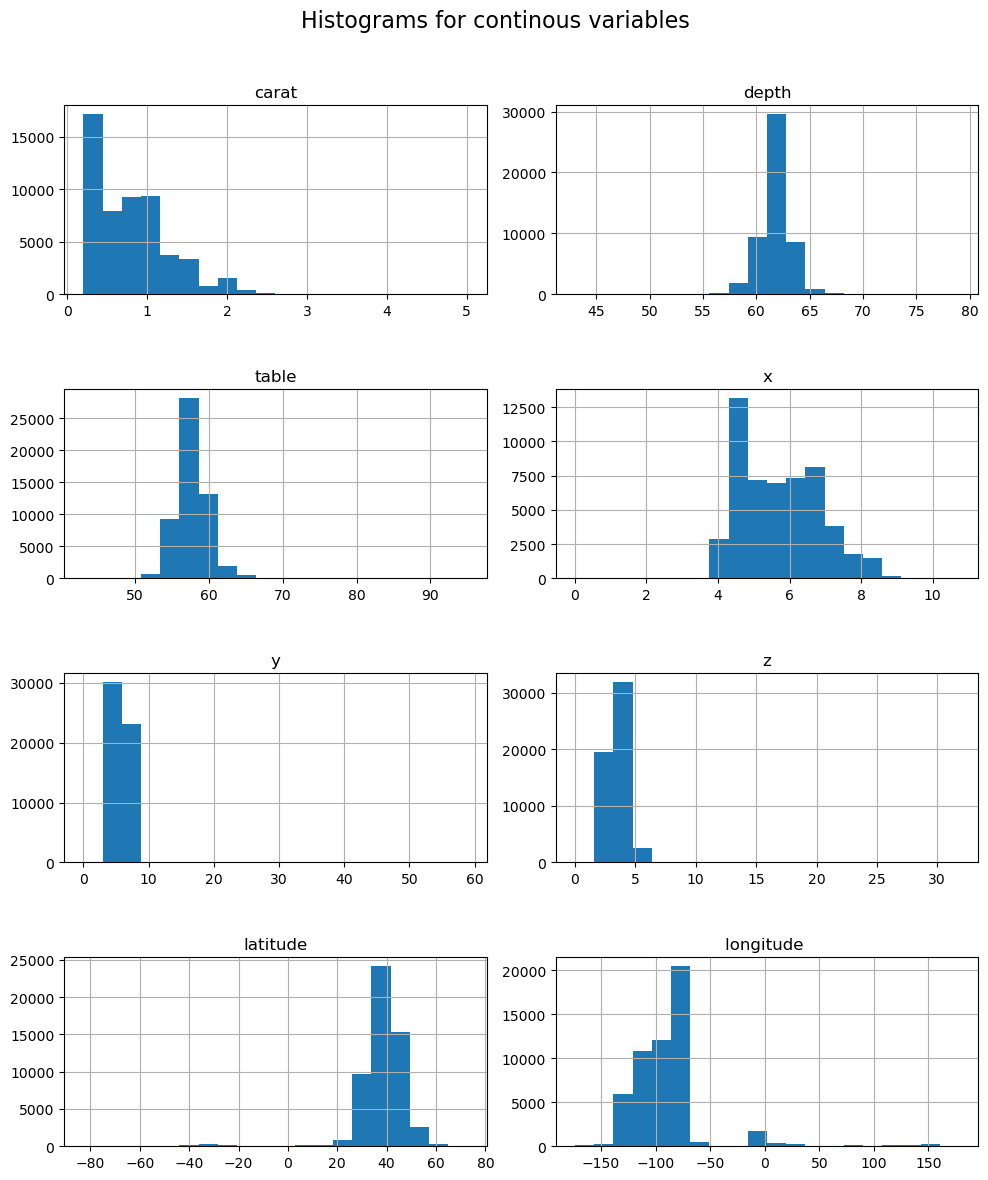

In [42]:
cont_columns = ['carat', 'depth', 'table', 'x', 'y', 'z', 'latitude', 'longitude ']
num_variables = len(cont_columns)
num_rows = (num_variables + 1) // 2  
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, num_rows * 3)) 


for i, variable in enumerate(cont_columns):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    diamonds_df[variable].hist(bins=20, ax=ax)
    ax.set_title(variable)

if num_variables % 2 != 0:
    fig.delaxes(axs[num_rows - 1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.5)
plt.suptitle('Histograms for continous variables', fontsize=16)
plt.show()

*Removing outliers*
First thing I addressed to eliminate the skeweness was deleting otuliers. I created a function to identify the upper and lower thresholds based on standard deviation to use them as limits to keep an observation. You can see how recursevely the number of observation decreased from 53K to 49K. I decided that the number of deleted data was small enough not to affect the model. 

In [43]:
# Recuersevely start deleting outliers
clean_df = diamonds_df.copy()

for column in ['carat', 'depth', 'table', 'x', 'y', 'z']:
    clean_df = remove_outliers_sd(clean_df, column)
    print("column: ", column, " ", clean_df.shape[0])

column:  carat   53518
column:  depth   49939
column:  table   49492
column:  x   49486
column:  y   49485
column:  z   49471


*Encoders*
With the corrections I made to the categorical value we get a small set of classes for each categorical value. It is very interesting to see that the classes for all the variables have ordinality (for instance Premium is better than Ideal and Ideal is better than Good), therefore I can use ordinal encoder to convert the classes to number to later input in a regression problem. 

The ordinal mapping is presented below. 

Finally, we re run de the dqr to ensure the encoding was made correctly, and in fact you can see that now we have a cleaned set of data that now will be ready to use in a predictive model. It is important to say that depending on the model selection some assumptions might be satisfied which will implay further data handling such as standardization, normallity, etc., however, having the data set cleaned is key to proceed with such processes.

In [44]:
# Creating the ordinal encoder
cut_mapping = {
    'Fair': 1,
    'Good': 2,
    'VeryGood': 3,
    'Premium': 4,
    'Ideal': 5
}

color_mapping = {
    'J': 1,
    'I': 2,
    'H': 3,
    'G': 4,
    'F': 5,
    'E': 6,
    'D': 7
}

clarity_mapping = {
    'I1': 1,
    'SI2': 2,
    'SI1': 3,
    'VS2': 4,
    'VS1': 5,
    'VVS2': 6,
    'VVS1': 7,
    'IF': 8
}

# Apply the encoding to the dataset
clean_df['cut'] = clean_df['cut'].map(cut_mapping)
clean_df['color'] = clean_df['color'].map(color_mapping)
clean_df['clarity'] = clean_df['clarity'].map(clarity_mapping)

print(tabulate(dqr(clean_df), headers='keys', tablefmt='pretty', showindex=False))


+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   Names   |  Type   | Missing_values | Present_values | Unique_values |  Min_value  | Max_value  |
+-----------+---------+----------------+----------------+---------------+-------------+------------+
|   carat   | float64 |       0        |     49471      |      203      |     0.2     |    2.22    |
|    cut    |  int64  |       0        |     49471      |       5       |     1.0     |    5.0     |
|   color   |  int64  |       0        |     49471      |       7       |     1.0     |    7.0     |
|  clarity  |  int64  |       0        |     49471      |       8       |     1.0     |    8.0     |
|   depth   | float64 |       0        |     49471      |      86       |    57.5     |    66.0    |
|   table   | float64 |       0        |     49471      |      106      |    51.0     |    63.5    |
|   price   |  int64  |       0        |     49471      |     11049     |    326.0    |  18

Finally I'll save in the data folder the cleaned data so this process is not repeated after each model tryout

In [45]:
save_preprocessed_data(clean_df, 'data/cleaned_data.csv')